<a href="https://colab.research.google.com/github/fblondiaux/LGBIO2072-2020/blob/master/LGBIO2072_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP2 - Firing Rate
__Authors:__ Antoine de Comite and Florence Blondiaux

__Content inspired from__: Neuromatch Academy github.com/NeuromatchAcademy

---

**Please run the cells below to initialize the notebook**

In [30]:
#@title Useful libraries and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, requests

def rand_syn(t,sigma = 0.1, imean = 25e-11):
    dt = t[1]-t[0]
    return imean * (1 + 0.1 * (np.sqrt(np.max(t)/dt)) * np.random.normal(0,sigma,len(t)))

def step_current(t,sigma = 0.1, imean = 25e-11):
    """
    Returns a step current, with step mean =  25e-11
    """
    i = np.zeros_like(t)
    i[int(len(t)/2):] = 1 #step
    i = i+np.random.normal(0,sigma,len(t)) 
    return imean * i
def DC_current(t,imean):
    """
    Returns dc current for a widget DONOT CHANGE
    """
    i = imean*np.ones_like(t)
    return i

def LIF(input_current,t,  tau= 20e-3 , urest= -60e-3 , r= 100e6, ureset = -70e-3 \
               ,theta = -50e-3, t_ref = 10e-3 ): 
    """
    Authors : Antoine de Comite and Florence Blondiaux
    Simulate the LIF model in response to an external input current
    Args:
      input_current   : Vector containing the input current [A].
      t               : Vector containing the discretized time points [s]
      tau             : Membrane time constant. Default value: 20e-3 [s]
      urest           : Leak potential. Default value: -60e-3 [V]
      r               : Leak resistance. Default value: 100e6 [Ohm]
      ureset          : Reset potential. Default value: -70e-3[V]
      theta           : Firing threashold. Default value: -50e-3 [V]
      t_ref           : Refractory period. Default value: 10e-3 [S]
    Returns:
      u               : membrane potential [V]
      ts              : spike times [s]
    """
    u = np.zeros_like(input_current)
    ts = []
    dt = t[1]-t[0]
    S = np.zeros_like(input_current)
    u[0]=urest
    t_wait = 0
    for step in range(0,len(input_current)-1):
        if u[step] > theta:
            u[step]= theta / 1.2
            u[step+1] = ureset
            t_wait = t_ref/dt
            ts.append((step+1)*dt)
        elif t_wait >0:
            u[step +1] = ureset
            t_wait -=1
        else:
            u[step+1]=u[step] -dt/tau * (u[step]-urest) + r*dt/tau * input_current[step]
    return u, ts

def load_dataset():
  url = 'https://raw.githubusercontent.com/fblondiaux/LGBIO2072-2020/master/ExtraContent/Output_Current.csv'
  df = pd.read_csv(url)
  S = df.to_numpy()
  return S
def plot_data(S):
  for i in range(len(S)):
    spike_times = S[i]
    plt.scatter(np.where(S[i,:]==1),i*np.ones_like(np.where(S[i,:]==1)),facecolor='skyblue',edgecolor = "white")
    plt.xlabel('Time [mS]')
    plt.ylabel('Neuron')
import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
# use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20,4]
rcParams['font.size']=15
rcParams['axes.spines.top']= False
rcParams['axes.spines.right']=False
rcParams['figure.autolayout']=False



In [35]:
#@title Widgets handling

import ipywidgets as widgtest #interactive display
%config InlineBackend.figure_format = 'retina'
#use NMA plot style
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")
my_layout = widgets.Layout()

---

# Tutorials Objectives

In the last tutorial, we implemented the LIF model of the neuron in which we modelled train of spikes from continuous input current. In this tutorial we will characterise and study these spike trains and discuss the messages they convey. At the end of this tutorial you should be able to : 

* Represent spike trains on a raster plot
* Convolve spike trains with different kernels to compute firing rates
* Compare the properties of the different kernels
* Compute the CV and the ISI distribution of a given firing pattern
* Understand the stochasticity of a neuron's firing pattern



---
# Reminders
## 1. Raster plot

A *raster plot* can be used to represent spike trains from multiple neurons (or from a single neuron modelled several times) by plotting dots at spike times `i` from neuron `j` at plot height `j` It can be useful to visualise the activity of several neurons at the same time. For example if we want to represent the spike times contained in `spike_time`, we can use :
```
plt.scatter(spike_times, j*np.ones_like(spike_times))
```

![spikes plot](https://github.com/mpbrigham/colaboratory-figures/raw/master/nma/python-for-nma/spikes_plot.png)

## 2. Firing rate 

Spikes alone are not very informative. However, looking closer at the spikes train can be very informative for example while focussing at firing rate and spiking regularities.

The firing rate can be computed by convolving a given kernel with the spike trains of interest. Let $t_{i=1}^{n}$ be the firing times and $S(t):=\sum_i \delta(t-t_i)$ the spike train. The firing rate $\rho(t)$ can be computed as the convolution of the spike train $S(t)$ with a given kernel $\kappa(t)$ : 

$$
\begin{eqnarray}
\rho(t) & =& \kappa(t) * S(t) = \int_{-\infty}^{\infty} \kappa(t)S(t-s)ds
\end{eqnarray}
$$

The shape of the kernel will slightly modify the values of the instantaneous firing rate. However, all kernels should roughly provide the same firing rate. 



---
# Exercises

## Exercise 1 

Model the responses of 500 neurons to a random input current and create the corresponding raster plot.

*Hints*
* Use the functions `plt.scatter`, `rand_syn`and `LIF`for this exercise

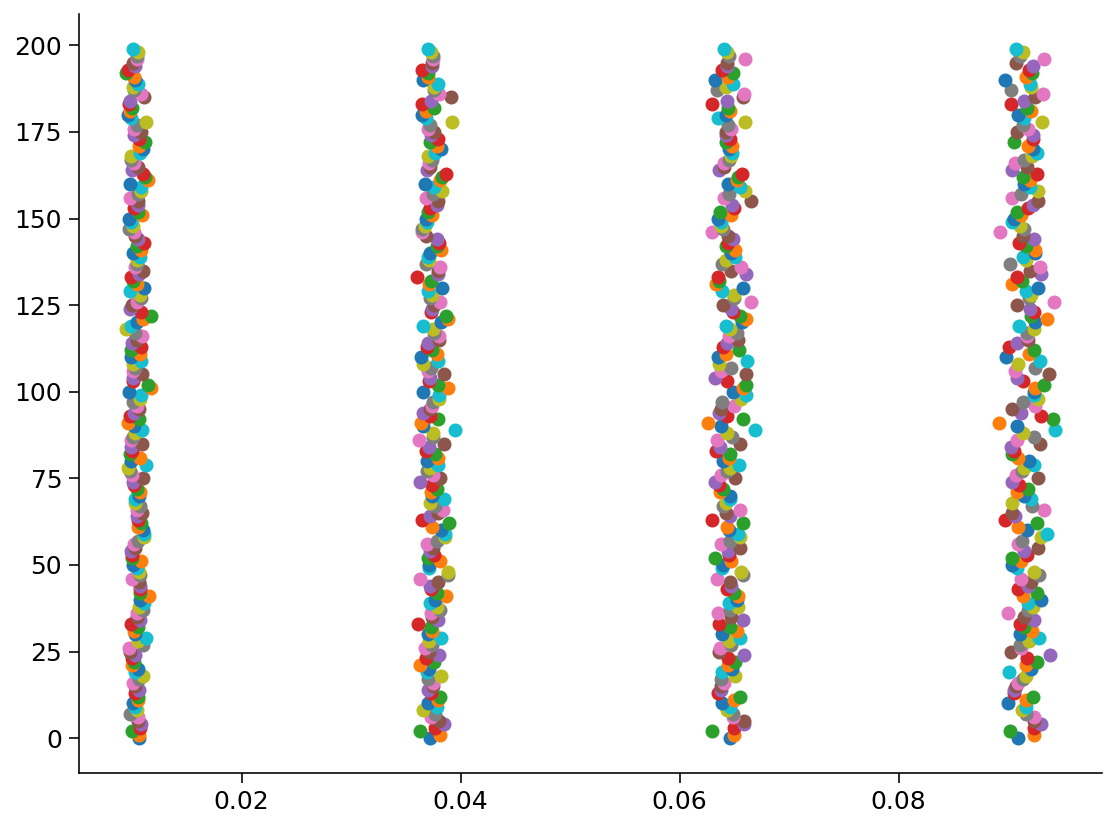

In [16]:
def make_raster_plot(N,t_range,sigma_in):
    """
    Computes the answer of N neurons to a random synaptic input current and plot the results as a raster plot
    
    Inputs : 
        N : Number of neurons
        t_range : Time-domain on which we want to investigate the neurons' responses
        sigma: Standard deviation of the noise of the input current 
    Outputs : 
        none
    """

    # Compute the responses of the neurons using the LIF function (do not forget to generate the input current )

    ######################
    ### your code here ###
    ######################
    dt = t_range[1]-t_range[0]
    
    spikeTimes = {}
    
    for n in range(N):
        u,spikeTimes[n] = LIF(rand_syn(t_range, sigma=sigma_in),t_range)
    

    # Represent these responses on a scatter plot (one line corresponds to one neuron)
    ######################
    ### your code here ###
    ######################
    for i in range(N):
        plt.scatter(spikeTimes[i], i*np.ones_like(spikeTimes[i]))
    return
# Run the lines below to test your code


t_max = 100e-3   # second
dt = .1e-3        # second
t_range = np.arange(0,t_max,dt)
make_raster_plot(200,t_range,sigma_in=0.1)

**Investigate the effect of the variance of the input current on the spike train regularities using the widget below.**

In [17]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    sigma=widgets.FloatSlider(0.8, min=0, max=2, step=0.25, layout=my_layout)

)

def raster_plot(sigma = 0.8):
    t_max = 150e-3   # second
    dt = 1e-3        # second
    step_end = int(t_max / dt) - 1
    t_range = np.linspace(0,dt*step_end,step_end)
    
    make_raster_plot(200,t_range,sigma)



interactive(children=(FloatSlider(value=0.8, description='sigma', layout=Layout(width='450px'), max=2.0, step=…

<font color="red"> **Questions** 
</font>

* What is the influence of the covariance of the noise of the input current on the spike patterns?

* How could you explain this based on the LIF model? 


---

## Exercice 2a

Compute the firing rate using a rectangular kernel $ \kappa(t)= (\Delta t)^{-1} 1_{0 \leq t \leq \Delta t} $. $\rho(t)$ will therefore be the spike count in a sliding window of side $\Delta t = \text{width}$.

Hint: use the `convolve` function from numpy (read the documentation for the different arguments that this function takes)

An experimenter records from a neuron while stimulating with some input sequence. The same stimulation sequence is repeated several times and the neuronal response is reported in a Peri-Stimulus-Time Histogram (PSTH) with bin width Δt;


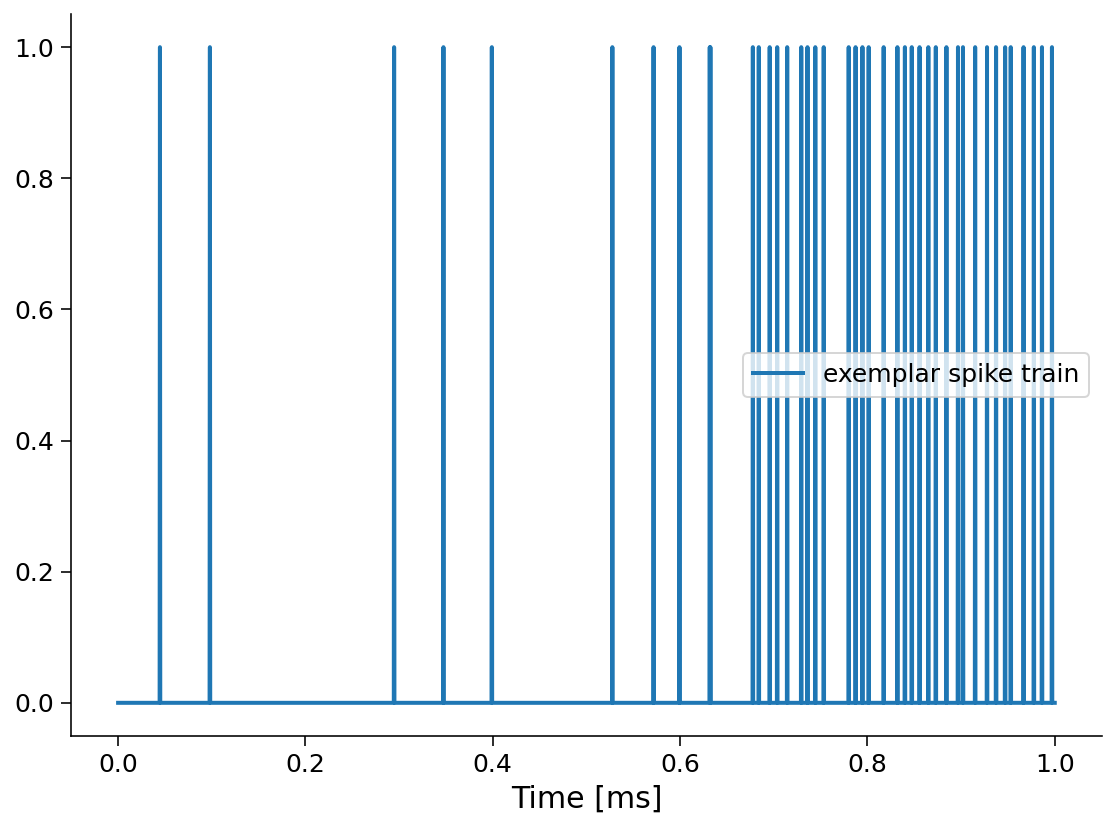

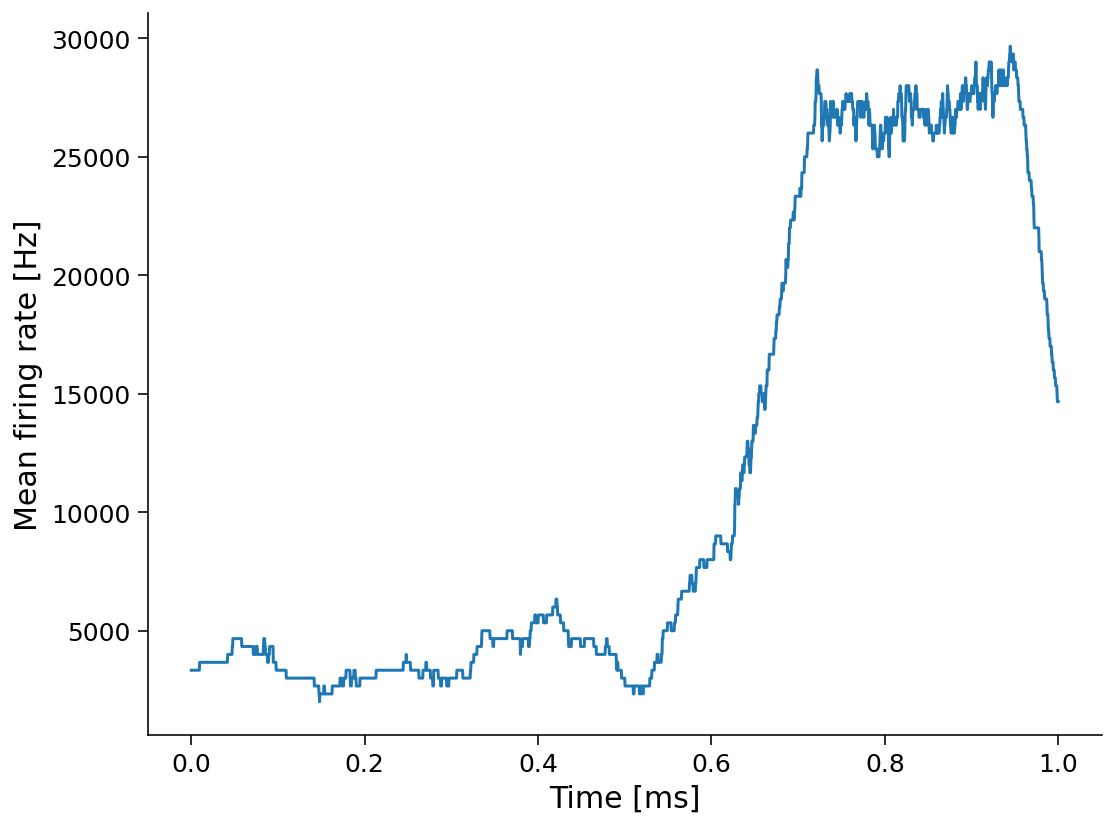

In [76]:
def firing_rate(S,kernel):
    """
    firing rate is a function that computes the firing rate from the spike trains and a given kernel

    Inputs : 
    -S (numpy array) is the spike train we want to compute the firing rate for
    -kernel (numpy array) is the kernel used for the convolution

    Outputs :
    -firing rate (numpy array) is the resulting firing rate 
    """
    ######################
    ### your code here ###
    ######################
    
    firing_rate = np.convolve(S,kernel,'same')

    
    return firing_rate

def rect_kernel(t_range,width):
    """
    rect_kernel creates the rectangular kernel used to compute the firing rate

    Inputs : 
    -time_vector is the time span on which we want to define this kernel
    -width is the width of the rectangular kernel (in the same units as dt)

    Outputs :
    -kernel is the returned rectangular kernel
    """
    ######################
    ### your code here ###
    ######################
    dt = t_range[1]-t_range[0]
    kernel = np.zeros_like(t_range)
    widthDt = int(width/dt)
    #center the kernel to limit boundary effects
    kernel[int((len(kernel)/2)-(widthDt/2)):int((len(kernel)/2)+(widthDt/2))] = np.ones(widthDt)/dt
    
    return kernel

# Run the lines below to test your code

# Data_loading
S = load_dataset()
Firing_rate = np.zeros_like(S)
t_range = np.linspace(0,1,S.shape[1])


#Compute the firing rate for all the neurons in the dataset

kernel = rect_kernel(t_range,100e-3)
for ii in range(Firing_rate.shape[0]):
  Firing_rate[ii,:] = firing_rate(S[ii,:],kernel)

#Plot the averaged firing rate
mean_firing_rate = np.mean(Firing_rate,0)

fig, ax1 = plt.subplots()
ax1.plot(t_range,S[1,:],label="exemplar spike train",linewidth=2)
ax1.set_xlabel('Time [ms]')
ax1.legend()

fig, ax = plt.subplots()
ax.plot(t_range,mean_firing_rate)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Mean firing rate [Hz]")
plt.show()

In [57]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    width=widgets.FloatSlider(200, min=10, max=1000, step=20, layout=my_layout)

)
def firingRate(width = 200):
    S = load_dataset()
    t_range = np.linspace(0,1,S.shape[1])
    kernel = rect_kernel(t_range,width*(t_range[1]-t_range[0]))
    
    Firing_rate = np.zeros_like(S)

    for ii in range(Firing_rate.shape[0]):
      Firing_rate[ii,:] = firing_rate(S[ii,:],kernel)
    mean_firing_rate = np.mean(Firing_rate,0)
    fig, ax=plt.subplots()
    ax.plot(t_range,mean_firing_rate)
    plt.show()

interactive(children=(FloatSlider(value=200.0, description='width', layout=Layout(width='450px'), max=1000.0, …

## Exercise 2b 

Compute the firing rate using a gaussian kernel defined by : 

$$
\begin{eqnarray}
\kappa(t) & =&  \dfrac{1}{\sigma\sqrt{2\pi}}\exp\left(-\dfrac{\left(t-t_f\right)^2}{2\sigma^2}\right)
\end{eqnarray}
$$

where the width of the convolution kernel is defined by the parameter $\sigma$. 

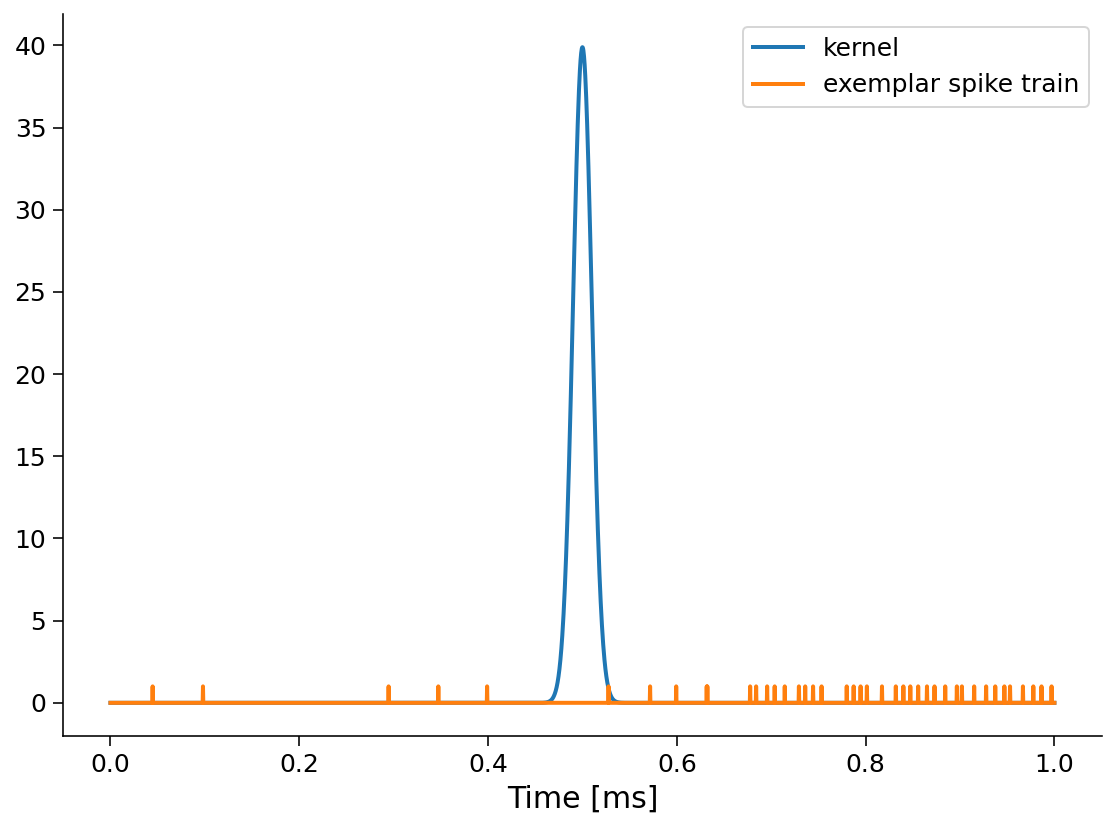

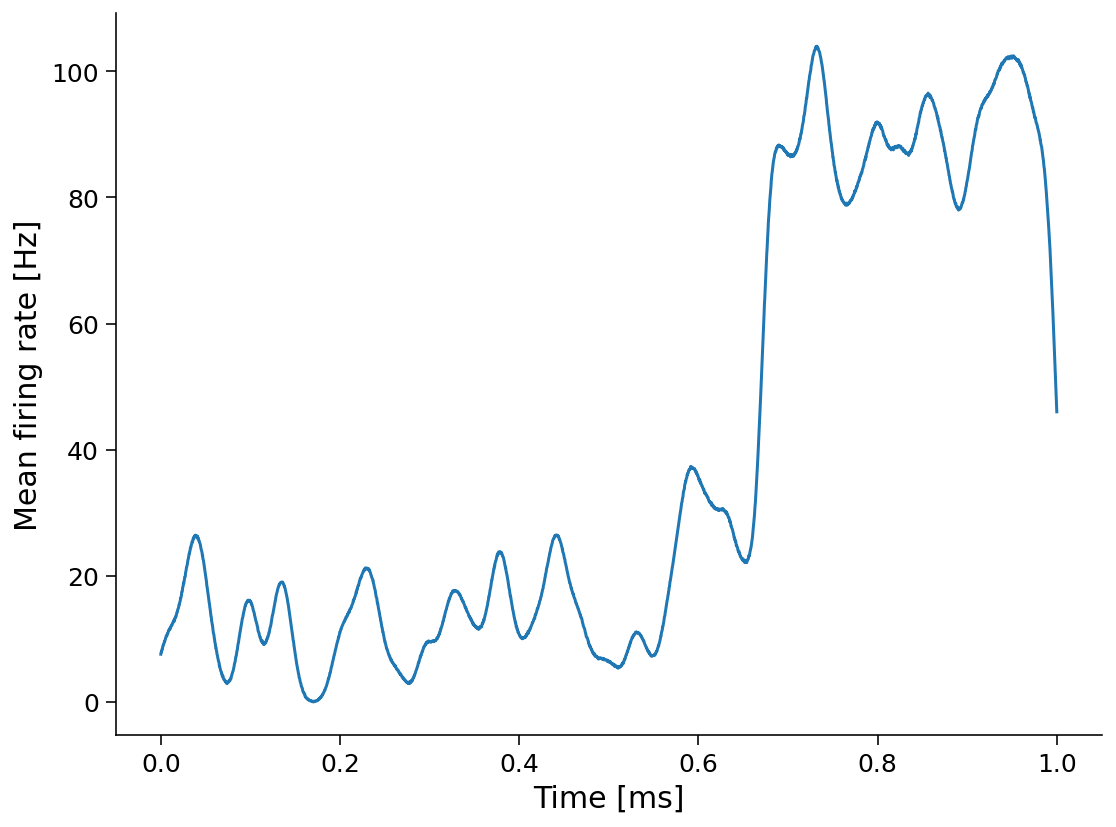

In [58]:
def gaussian_kernel(time_vector,sigma):
  """
  This function generates the gaussian kernel to compute the firing rate of a given spike trains

  Inputs : 
  -time_vector is the time span of the kernel
  -sigma is the width of the gaussian distribution

  Outputs:
  -kernel is the distribution
  """

  kernel = 1/(sigma*np.sqrt(2*np.pi)) * np.exp(-(time_vector-time_vector[-1]/2)**2/(2*sigma**2))
  ######################
  ### your code here ###
  ######################
  
  
  return kernel

#Run the lines below to test your code

# Load data
S = load_dataset()
Firing_rate = np.zeros_like(S)
t_range = np.linspace(0,1,S.shape[1])


#Compute the firing rate for all the neurons in the dataset
kernel = gaussian_kernel(t_range,0.01)
for ii in range(Firing_rate.shape[0]):
  Firing_rate[ii,:] = firing_rate(S[ii,:],kernel)


#Plot the averaged firing rate
mean_firing_rate = np.mean(Firing_rate,0)

fig, ax1 = plt.subplots()
ax1.plot(t_range,kernel,label="kernel",linewidth=2)
ax1.plot(t_range,S[1,:],label="exemplar spike train",linewidth=2)
ax1.set_xlabel('Time [ms]')
ax1.legend()

fig, ax = plt.subplots()
ax.plot(t_range,mean_firing_rate)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Mean firing rate [Hz]")
plt.show()





<font color="red"> **Questions** 
</font>


Use the widget below to investigate the effect the standard deviation of the Gaussian kernel on the computation of the firing rate. What do you observe? 

In [63]:
# @title
# @markdown Make sure you execute this cell to enable the widget! Sigma is expressed in ms.
my_layout.width = '450px'
@widgets.interact(
    sigma=widgets.FloatSlider(20, min=1, max=100, step=5, layout=my_layout)

)
def firingRate(sigma =0.1):
    S = load_dataset()
    t_range = np.linspace(0,1,S.shape[1])
    kernel = gaussian_kernel(t_range,sigma*1e-3)
    
    Firing_rate = np.zeros_like(S)

    for ii in range(Firing_rate.shape[0]):
      Firing_rate[ii,:] = firing_rate(S[ii,:],kernel)
    mean_firing_rate = np.mean(Firing_rate,0)
    fig, ax=plt.subplots()
    ax.plot(t_range,mean_firing_rate)
    plt.show()

interactive(children=(FloatSlider(value=20.0, description='sigma', layout=Layout(width='450px'), min=1.0, step…

# Exercise 2c [BONUS]

Implement an exponential kernel and compute the corresponding firing rate. The exponential kernel has assymetric rise and fall constants inspired from the biology. It is defined by the following : 

$$
\begin{eqnarray}
\kappa(t) = C \left(1-\exp\left(\dfrac{-t}{T_R}\right) \right) \exp\left(\dfrac{-t}{T_F}\right) 
\end{eqnarray}
$$

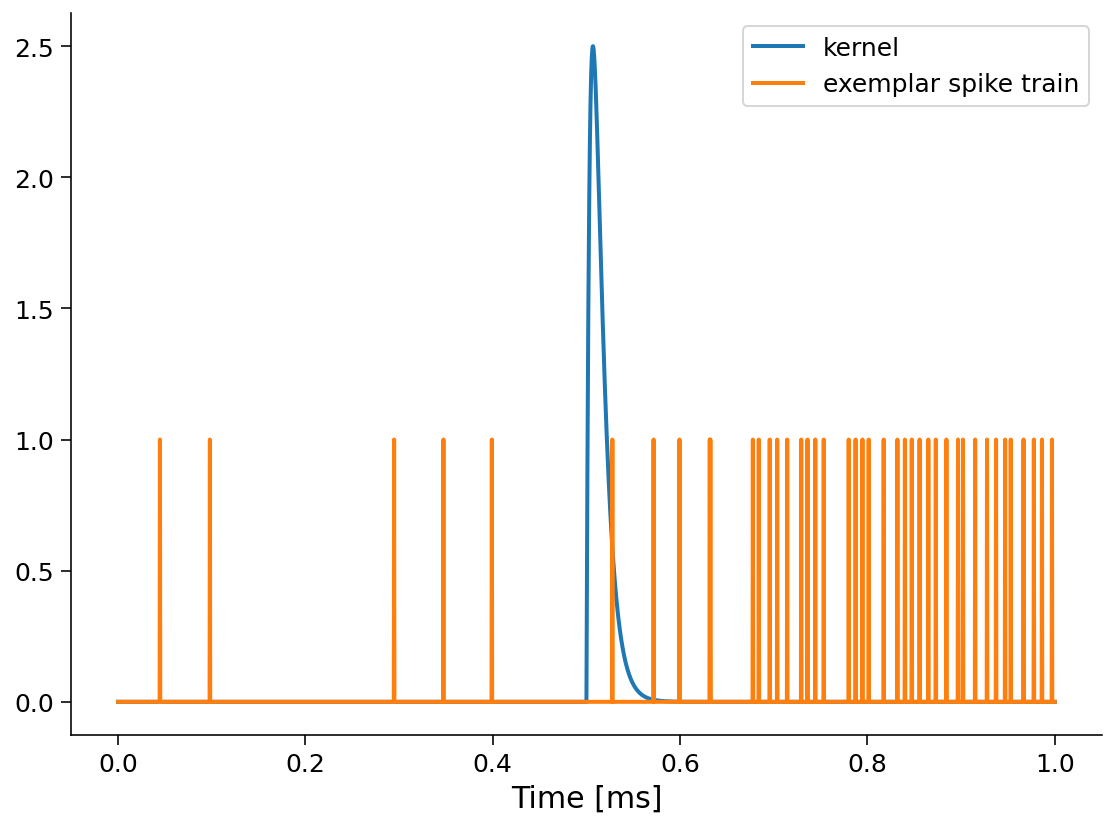

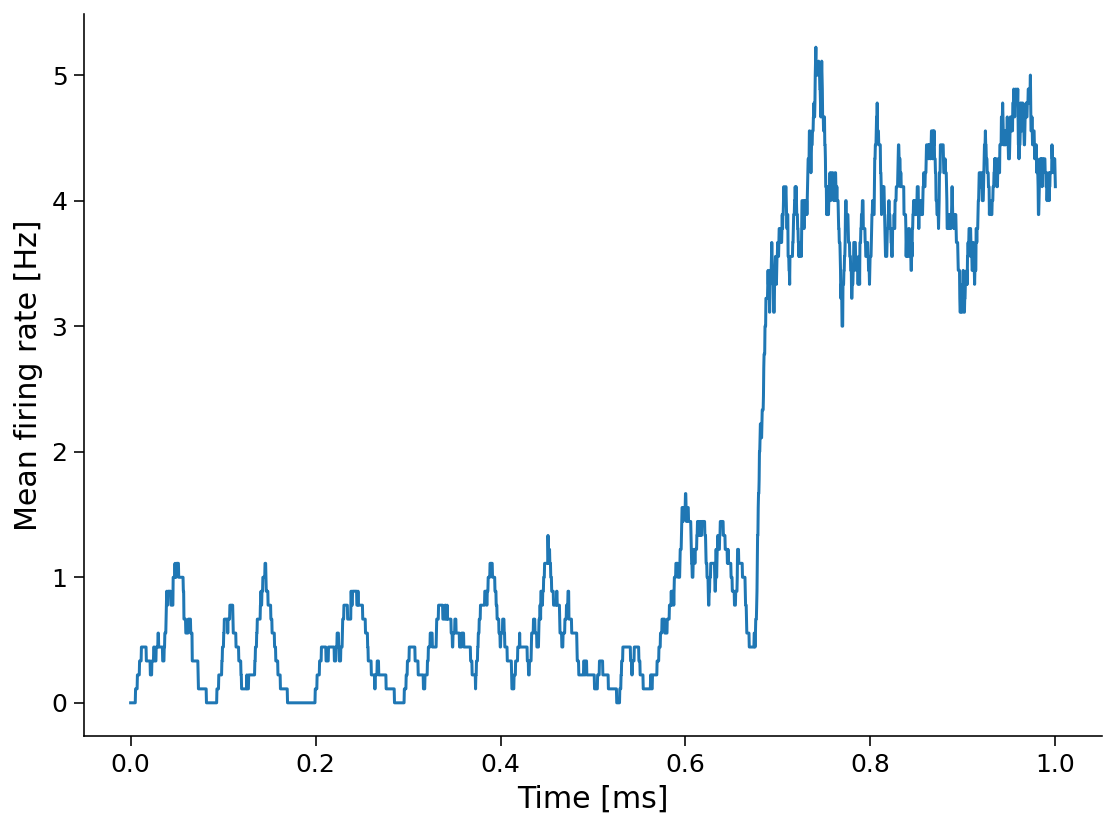

In [81]:
def exponential_kernel(time_vector,C,Tr,Tf):
    """
    This functions generates the exponential kernel to compute the firing rate of a given spikes train

    Inputs : 
    -time_vector is the time span of the kernel
    -C is a normalizing constant
    -Tr is the rising time
    -Tf is the falling time

    Outputs : 
    -kernel is the generated kernel
    """

    ######################
    ### your code here ###
    ######################

    return kernel

# Load data
S = load_dataset()
Firing_rate = np.zeros_like(S)
t_range = np.linspace(0,1,S.shape[1])


#Compute the firing rate for all the neurons in the dataset
kernel = exponential_kernel(t_range,10, 10e-3,10e-3)
for ii in range(Firing_rate.shape[0]):
  Firing_rate[ii,:] = firing_rate(S[ii,:],kernel)


#Plot the averaged firing rate
mean_firing_rate = np.mean(Firing_rate,0)

fig, ax1 = plt.subplots()
ax1.plot(t_range,kernel,label="kernel",linewidth=2)
ax1.plot(t_range,S[1,:],label="exemplar spike train",linewidth=2)
ax1.set_xlabel('Time [ms]')
ax1.legend()

fig, ax = plt.subplots()
ax.plot(t_range,mean_firing_rate)
ax.set_xlabel("Time [ms]")
ax.set_ylabel("Mean firing rate [Hz]")
plt.show()

---

## Exercise 3

In the first exercise, we observed that the firing rate pattern is modified by the covariance of the noise of the input current. In this exercise, we will investigate this phenomenon and determine whether there is a linear relationship between input current amplitude and firing rate.

In order to do that, use the functions you defined above to compute the firing rates of the neurons with varying input currents. 

In [84]:
#we will use rec_kernel & firing_rate in this exercise 
my_layout.width = '450px'
@widgets.interact(
    sig_gwn=widgets.FloatSlider(3.0, min=0., max=6., step=0.5,
                                layout=my_layout)
)
def diff_std(sig_gwn):
    I_mean = np.arange(0,400e-12,10e-12)
    spk_count = np.zeros_like(I_mean)
    spk_count_DC = np.zeros_like(I_mean)
    time_vector = np.arange(0.,1.,0.001)
    for idx in range(len(I_mean)):
        I_GWN = rand_syn(time_vector,sigma=sig_gwn,imean=I_mean[idx])
        I_DC = DC_current(time_vector,I_mean[idx]) 
        u,ts = LIF(I_GWN,time_vector)
        udc,tsdc = LIF(I_DC,time_vector)
        spk_count[idx] = len(ts)
        spk_count_DC[idx] = len(tsdc)



    fig, ax = plt.subplots()
    ax.plot(I_mean,spk_count,'k')
    ax.plot(I_mean,spk_count_DC,'r')
    ax.set_xlabel("Mean Current")
    ax.set_ylabel("Nb Spike/s")
    ax.legend(["Gaussian White Noise Current", "DC current"])

interactive(children=(FloatSlider(value=3.0, description='sig_gwn', layout=Layout(width='450px'), max=6.0, ste…

<font color="red"> **Questions** 
</font>

* Is the relationship between input current amplitude and firing rate linear? 

* Could it be linear in some amplitude/variance range for the input current? 

* How could you verify/quantify this ? 

---
# Stochasticity of neuronal activity

In the last section, we saw how to compute the firing rate with different kernels and we observed that the way neurons convey information is by their spiking patterns. In this section, we will investigate the stochasticity of these spiking patterns. 

**Reminder**

Spike regularity can be quantified as the *coefficient of variation (CV) of the inter-spike-interval (ISI)*:
\begin{align}
\text{CV}_{\text{ISI}} = \dfrac{\text{std}(\text{ISI})}{\text{mean}(\text{ISI})}
\end{align}

The inter-spike-interval being the time elapsed between two successive spikes. 

---
## Exercise 4

Compute the inter-spike interval distribution as well as the coefficient of variation of spike trains provided in $S$ to assess the stochasticity of neuron's activity. Plot the ISI distribution with an histogram to visualize the spike regularity of the different neurons. 

Hint :

* You can use the function `np.diff`
* You can use the function `hist`from `matplotlib.pyplot`to represent the resulting distribution

A Poisson train is an example of high irregularity, in which $\textbf{CV}_{\textbf{ISI}} \textbf{= 1}$. And for a clocklike (regular) process we have $\textbf{CV}_{\textbf{ISI}} \textbf{= 0}$ because of **std(ISI)=0**.


1.2775574774283998


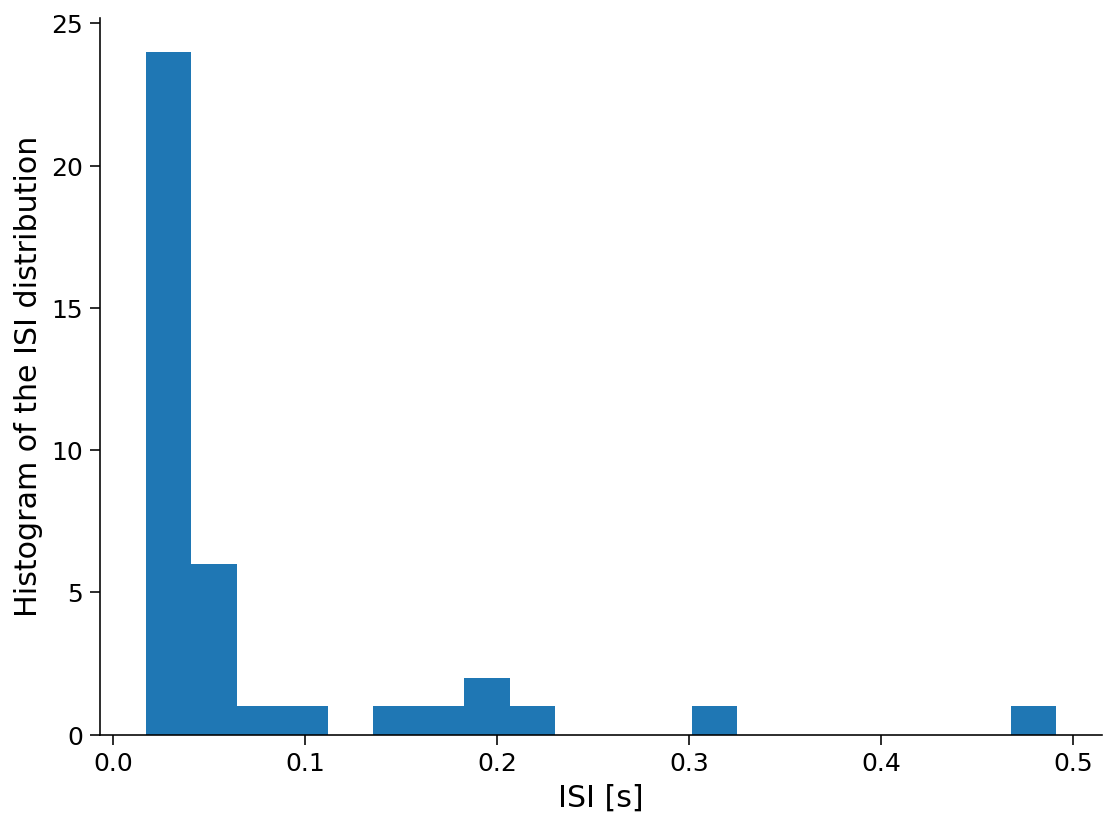

In [92]:
def compute_ISI(spiketrain,dt):
    """
    This function computes and plots the ISI distribution and returns the coefficient of variation and the interspike interval distribution

    Inputs : 
    -spiketrain is the spike pattern under investigation [0 0 0 ... 0 1 0]
    -dt is the time step

    Outputs :
    -CV is the coefficient of variation
    -ISI is the interspike interval distribution
    """

    ######################
    ### your code here ###
    ######################
    ISI = np.diff((np.where(spiketrain))[0]*dt)
    CV = np.std(ISI)/np.mean(ISI)
        
    return ISI, CV

# Run the lines below to test your code 

S = load_dataset()
ISI,CV = compute_ISI(S[0,:],1e-3)
fig, ax=plt.subplots()
ax.hist(ISI,20)
ax.set_xlabel("ISI [s]")
ax.set_ylabel("Histogram of the ISI distribution")


**Use the widget below to investigate the ISI for the different neurons**

In [96]:
# @title
# @markdown Make sure you execute this cell to enable the widget!
my_layout.width = '450px'
@widgets.interact(
    neuron=widgets.IntSlider(0, min=0, max=8, step=1, layout=my_layout)

)

def firingRate(neuron = 0):
        
    S = load_dataset()
    ISI, CV=compute_ISI(S[neuron,:],dt)
    print("The CV for neuron", neuron, "is :", CV)
    fig, ax=plt.subplots()
    ax.hist(ISI,20)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Histogram of the ISI distribution")

interactive(children=(IntSlider(value=0, description='neuron', layout=Layout(width='450px'), max=8), Output())…

<font color="red"> **Questions** 
</font>

* How can you relate the ISI to scatter plots?
* Is is possible to have an idea about CV while looking at the ISI's? 

---
## Exercise 5 - Poisson process

Variability in neuron's activity can be approximated by a Poisson process. In this case, the interspike interval distribution can be approximated by an exponential distribution. In the following exercise, create a Poisson type spike trains. 


The generation of the Poisson process can be performed by at least two processes:

- By definition, for a Poisson process with rate $\lambda$, the probability of finding one event in the time window with a sufficiently small length $\Delta t$ is $P(N = 1) = \lambda \Delta t$. Therefore, in each time window, we generate a uniformly distributed random variable $r \in [0,1]$ and generate a Poisson event when $r <\lambda \Delta t$. This method allows us to generate Poisson distributed spikes in an online manner.


- The interval $t_{k+1}-t_{k}$ between two Poisson events with rate $\lambda$ follows the exponential distribution, i.e., $P(t_{k+1}-t_{k}<t) = 1 - e^{\lambda t}$. Therefore, we only need to generate a set of exponentially distributed variables $\{s_k\}$ to obtain the timing of Poisson events $t_{k+1}=t_{k}+s_{k}$. In this method, we need to generate all future spikes at once. 

Below, we use the first method in a function `Poisson_generator`, which takes arguments time_range, n and rate.

[ 84 109 155 326 494 525 829 999]


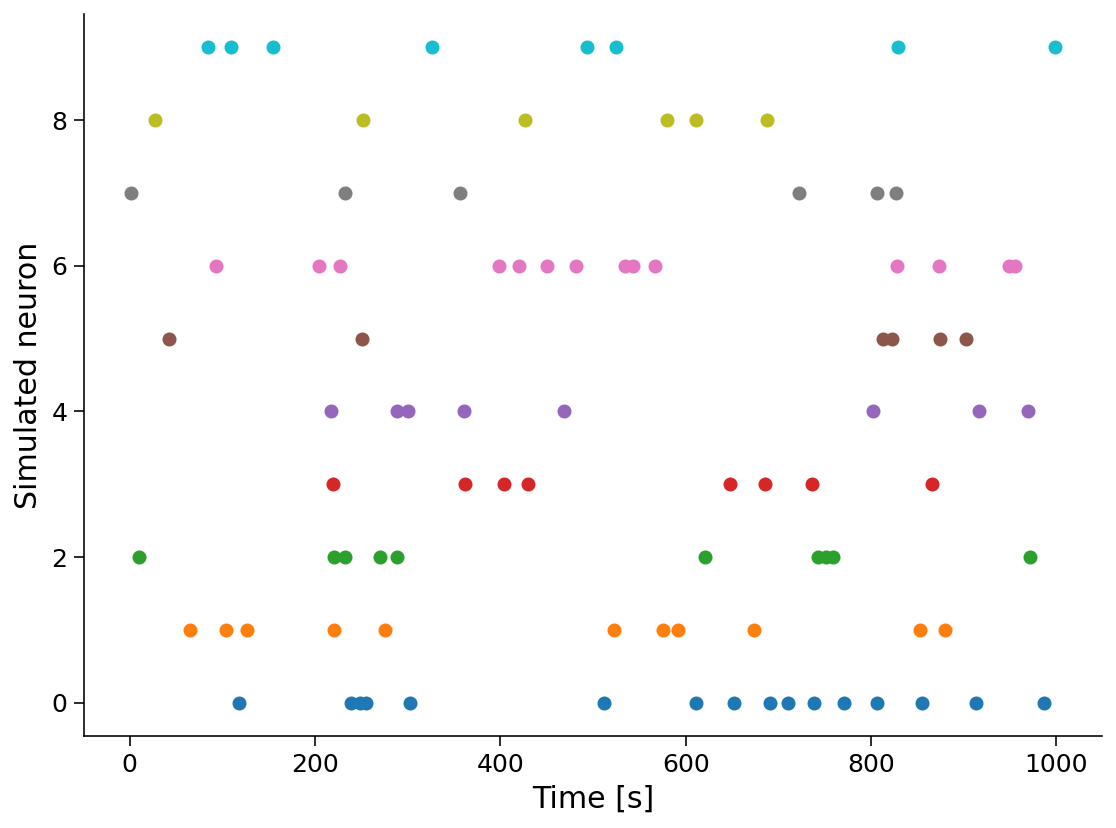

In [109]:
def Poisson_generator(time_range,n,rate):
    """
    Poisson generator generates n Poisson like spike trains

    Inputs : 
    -time_range is the time vector on which we are evolved
    -n is the number of spike trains to generate
    -rate is the rate of the poisson process

    Outputs:
    -poisson_trains are the generated poisson spike trains
    """
    ######################
    ### your code here ###
    ######################
    
    dt = time_range[1]-time_range[0]
    L = len(time_range)
    u_rand = np.random.rand(n,L)
    poisson_train = 1.*(u_rand< rate*dt)
    
    return poisson_train

#Run the lines below to test your code

time_range = np.linspace(0,1,1000)
n = 10 
rate = 10
poisson_spikes = Poisson_generator(time_range,n,rate)
fig, ax=plt.subplots()
ax.set_xlabel("Time [s]")
ax.set_ylabel("Simulated neuron")

print(np.where(poisson_spikes[i,:])[0],)
for i in range(n):
    spike_times = np.where(poisson_spikes[i,:])[0]
    plt.scatter(spike_times, i*np.ones_like(spike_times))


---
## Exercise 6 - Inferring the firing rate from the spiking train

In the last exercise, we observed that the spiking patterns of neurons can be reproduced using a Poisson process (if CV~=1) . This means that, assuming that the neuron behave as a poisson process, it is possible to determine the firing rate. 

The idea is to estimate the firing rate based on Bayesian statistics. Imagine that you count a number of spikes $k$ during one second. The PSTH is equal to the spike count, so simply $k$ spikes. Now we could use Poisson model if the coefficient of variation is close to one (we have discussed it in the course). The probability that the number of spikes equal $k$ given a rate of $\rho$ is:
\begin{eqnarray*}
P(N = k | \rho) = \frac{e^{-\rho}\rho^k}{k!},
\end{eqnarray*}
to which we can apply Bayes' theorem to estimate $\rho$:
\begin{eqnarray*}
P(\rho| N = k ) &\propto& P(N = k | \rho) P(\rho),\\
P(\rho| N = k ) &\propto& \frac{e^{-\rho}\rho^k}{k!} P(\rho),
\end{eqnarray*}
where $P(\rho)$ expresses the prior. If we do not have any prior assumption we can use a flat, non-informative prior. Thus the posterior distribution can be approximated numerically by evaluating $P(N=k|\rho)$ for different vaules of $\rho$ and dividing by the sum so that it integrates to 1.

Apply this in the exercise below by completing the function `find_spikingrate`.

Text(0, 0.5, 'P(rho)')

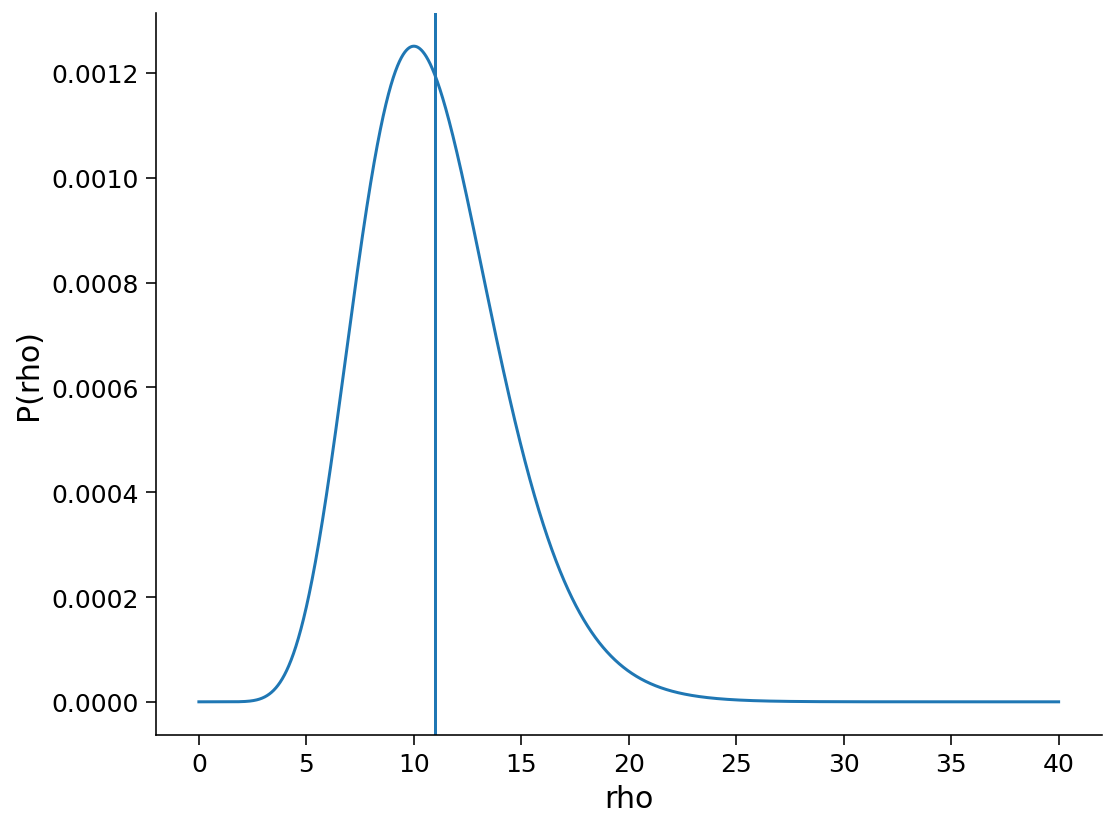

In [112]:
def find_spikingrate(k,rhocandidate,dt):
    """
    This function computes the best firing rate candidate based on the number of spikes observed per second

    Inputs : 
    -k is the number of spikes observed in dt seconds
    -rhocandidate is the set of rho we want to test
    -dt is the time during which the spikes are counted
    """

    ######################
    ### your code here ###
    ######################
    
    posterior = np.exp(-rhocandidate) * (rhocandidate)**k 
    posterior = posterior/np.sum(posterior)
    expected_value = posterior@rhocandidate
    
    return posterior, expected_value

#Run the lines below to test your code 

k = 10
dt=1
rhocandidate = np.arange(0,40,0.01)
posterior, expected_value = find_spikingrate(k,rhocandidate,dt)
drho = rhocandidate[1]-rhocandidate[0]
fig, ax = plt.subplots()
ax.axvline(expected_value)
ax.plot(rhocandidate,posterior)
ax.set_xlabel('rho')
ax.set_ylabel('P(rho)')


## Exercise 7 - Tuning of neurons

For this exercice we will use the Steinmetz dataset. During their study, Steinmetz and colleagues recorded the activity from approximately 30,000 neurons in 42 brain regions of mice performing a visual discrimination task. A stimulus was presented on a screen in front of the mouse, either on the left, on the right, or no stimulus at all. For each kind of stimulus, the mouse had to respond with a particular behaviour. For more information on the study click [here](https://www.nature.com/articles/s41586-019-1787-x).

**Run the cell below te investigate neurons tuning**

In [113]:
# @title
# @markdown Make sure you execute this cell to download the dataset!
fname =[]
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r=requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data""")
    else:
      with open(fname[j],"wb") as fid:
        fid.write(r.content)

from matplotlib import rcParams
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20,4]
rcParams['font.size']=15
rcParams['axes.spines.top']= False
rcParams['axes.spines.right']=False
rcParams['figure.autolayout']=False

alldat=np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat,np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

dat = alldat[11]
print("Dataset downloaded !") 

dict_keys(['spks', 'wheel', 'pupil', 'response', 'response_time', 'bin_size', 'stim_onset', 'contrast_right', 'contrast_left', 'brain_area', 'feedback_time', 'feedback_type', 'gocue', 'mouse_name', 'date_exp', 'trough_to_peak', 'active_trials', 'contrast_left_passive', 'contrast_right_passive', 'spks_passive', 'pupil_passive', 'wheel_passive', 'prev_reward', 'ccf', 'ccf_axes', 'cellid_orig', 'reaction_time', 'face', 'face_passive', 'licks', 'licks_passive'])


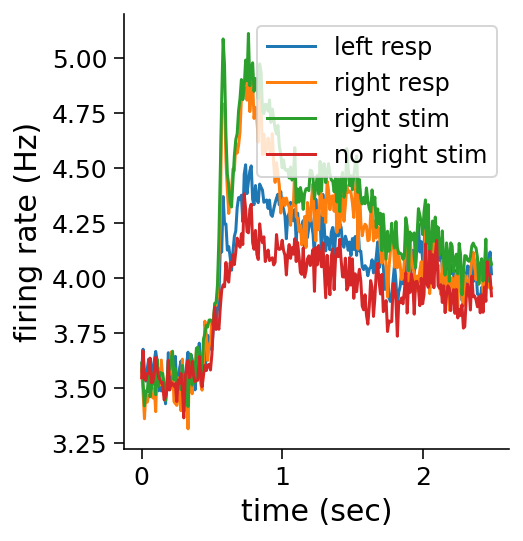

In [115]:
dt = dat['bin_size'] #binning at 10ms
NT = dat['spks'].shape[-1]

ax = plt.subplot(1,5,1)
response = dat['response'] #right - nogo - left (-1,0,0)
vis_right = dat['contrast_right']
vis_left = dat['contrast_left']
plt.plot(dt*np.arange(NT),1/dt*dat['spks'][:,response>=0].mean(axis=(0,1)))
plt.plot(dt*np.arange(NT),1/dt*dat['spks'][:,response<0].mean(axis=(0,1)))
plt.plot(dt*np.arange(NT),1/dt*dat['spks'][:,vis_right>0].mean(axis=(0,1)))
plt.plot(dt*np.arange(NT),1/dt*dat['spks'][:,vis_right==0].mean(axis=(0,1)))

plt.legend(['left resp','right resp','right stim','no right stim'], fontsize=12)
ax.set(xlabel='time (sec)',ylabel='firing rate (Hz)')
plt.show()

<font color="red"> **Questions** 
</font>

* How would you define neuron tuning? 

* Is there neuron tuning on the graph above? If yes, where? 